In [1]:
import osmium as osm
import pandas as pd

class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type):
        for tag in elem.tags:
            self.osm_data.append([elem_type, 
                                   elem.id, 
                                   elem.version,
                                   elem.visible,
                                   pd.Timestamp(elem.timestamp),
                                   elem.uid,
                                   elem.user,
                                   elem.changeset,
                                   len(elem.tags),
                                   tag.k, 
                                   tag.v])

    def node(self, n):
        self.tag_inventory(n, "node")

    def way(self, w):
        self.tag_inventory(w, "way")

    def relation(self, r):
        self.tag_inventory(r, "relation")


In [2]:
osmhandler = OSMHandler()
# scan the input file and fills the handler list accordingly
osmhandler.apply_file("test1.osm")

# transform the list into a pandas DataFrame
data_colnames = ['type', 'id', 'version', 'visible', 'ts', 'uid',
                 'user', 'chgset', 'ntags', 'tagkey', 'tagvalue']
df_osm = pd.DataFrame(osmhandler.osm_data, columns=data_colnames)

In [3]:
df_osm.head()

,type,id,version,visible,ts,uid,user,chgset,ntags,tagkey,tagvalue
0,node,245640568,1,True,1970-01-01 00:00:00+00:00,0,,0,2,source,AND
1,node,245640568,1,True,1970-01-01 00:00:00+00:00,0,,0,2,highway,crossing
2,node,245640573,1,True,1970-01-01 00:00:00+00:00,0,,0,1,source,AND
3,node,245640576,1,True,1970-01-01 00:00:00+00:00,0,,0,1,source,AND
4,node,245640607,1,True,1970-01-01 00:00:00+00:00,0,,0,4,name,Ambarpet


In [4]:
type(df_osm)

pandas.core.frame.DataFrame

In [5]:
df_osm['type'].unique()

array(['node', 'way', 'relation'], dtype=object)

In [6]:
df_osm.columns

Index(['type', 'id', 'version', 'visible', 'ts', 'uid', 'user', 'chgset',
       'ntags', 'tagkey', 'tagvalue'],
      dtype='object')

In [7]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

#### Also use ####

place_name = "Bangalore, Karnataka, India"

In [8]:
place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')

In [9]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

Okey so now we have retrieved only such streets where it is possible to drive with a car. Let’s confirm this by taking a look at the attributes of the street network. Easiest way to do this is to convert the graph (nodes and edges) into GeoDataFrames.



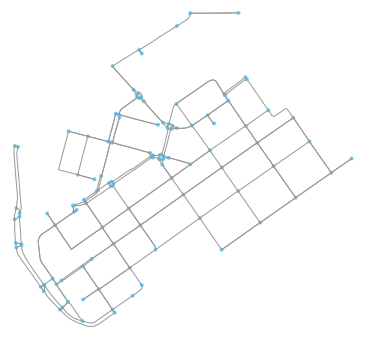

In [10]:
fig, ax = ox.plot_graph(graph)

In [11]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [12]:
type(edges)

geopandas.geodataframe.GeoDataFrame

In [13]:
edges.columns

Index(['access', 'bridge', 'geometry', 'highway', 'junction', 'key', 'lanes',
       'length', 'maxspeed', 'name', 'oneway', 'osmid', 'u', 'v'],
      dtype='object')

In [14]:
edges['highway'].value_counts()

residential      112
tertiary          78
primary           26
secondary         17
unclassified      11
living_street      4
primary_link       1
Name: highway, dtype: int64

Okey, now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways of footways included in the data. We can also see that the CRS of the GeoDataFrame seems to be WGS84 (i.e. epsg: 4326).



Let’s continue and find the shortest path between two points based on the distance. As the data is in WGS84 format, we might first want to reproject our data into metric system so that our map looks better. Luckily there is a handy function in osmnx called project_graph() to project the graph data in UTM format.



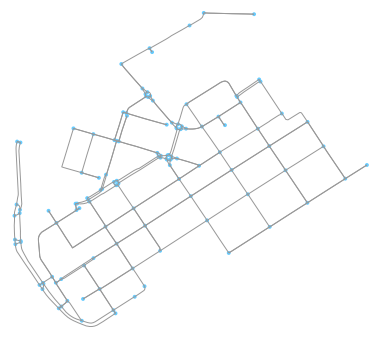

<Figure size 432x288 with 0 Axes>

In [15]:
graph_proj = ox.project_graph(graph)
fig, ax = ox.plot_graph(graph_proj)
plt.tight_layout()

In [16]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [17]:
edges_proj.shape

(249, 14)

In [18]:
nodes_proj.head()

,highway,lat,lon,osmid,x,y,geometry
25216594,NaN,60.1648,24.9211,25216594,384631,6.67158e+06,POINT (384631.3223718022 6671580.070624193)
25238874,NaN,60.1637,24.921,25238874,384626,6.67145e+06,POINT (384625.7872206579 6671454.380189306)
25238944,NaN,60.1646,24.9213,25238944,384643,6.67156e+06,POINT (384643.4732736854 6671561.533814663)
25291537,NaN,60.1643,24.937,25291537,385516,6.6715e+06,POINT (385515.6177361083 6671500.065126655)
25291564,NaN,60.1659,24.9417,25291564,385779,6.67167e+06,POINT (385779.465694473 6671672.812754457)


In [19]:
edges_proj.head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,u,v
0,NaN,NaN,LINESTRING (384631.3223718022 6671580.07062419...,primary,NaN,0,2,40.885,40,Mechelininkatu,True,23856784,25216594,1372425714
1,NaN,NaN,LINESTRING (384625.7872206579 6671454.38018930...,primary,NaN,0,3,16.601,40,Mechelininkatu,True,"[29977177, 30470347]",25238874,1372425713
2,NaN,NaN,LINESTRING (384643.4732736854 6671561.53381466...,primary,NaN,0,2,25.167,40,NaN,True,"[372440330, 8135861]",25238944,25216594
3,NaN,NaN,LINESTRING (384643.4732736854 6671561.53381466...,primary,NaN,0,2,242.477,40,Mechelininkatu,True,"[25514547, 30288797, 30288799]",25238944,319896278
4,NaN,NaN,LINESTRING (385515.6177361083 6671500.06512665...,tertiary,NaN,0,NaN,139.183,"[40, 30]",Fredrikinkatu,True,"[30568275, 36729015, 316590744, 316590745, 316...",25291537,25291591


In [20]:
from shapely.geometry import box

In [21]:
bbox = box(*edges_proj.unary_union.bounds)
print(bbox)

POLYGON ((385855.0300992894 6671142.734328128, 385855.0300992894 6672267.057001855, 384623.3898322977 6672267.057001855, 384623.3898322977 6671142.734328128, 385855.0300992894 6671142.734328128))


In [22]:
orig_point = bbox.centroid
print(orig_point)

POINT (385239.2099657935 6671704.895664991)


In [23]:
nodes_proj['x'] = nodes_proj.x.astype(float)

maxx = nodes_proj['x'].max()

target_loc = nodes_proj.loc[nodes_proj['x']==maxx, :]

print(target_loc)

                   highway      lat     lon      osmid              x  \
317703609  traffic_signals  60.1664  24.943  317703609  385855.030099   

                     y                                     geometry  
317703609  6.67172e+06  POINT (385855.0300992894 6671721.810323974)  


In [24]:
target_point = target_loc.geometry.values[0]

print(target_point)

POINT (385855.0300992894 6671721.810323974)


In [36]:
target_loc

,highway,lat,lon,osmid,x,y,geometry
317703609,traffic_signals,60.1664,24.943,317703609,385855.030099,6.67172e+06,POINT (385855.0300992894 6671721.810323974)


In [34]:
target_xy

(6671721.810323974, 385855.03009928943)

In [25]:
orig_xy = (orig_point.y, orig_point.x)

target_xy = (target_point.y, target_point.x)

orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')

target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')

o_closest = nodes_proj.loc[orig_node]

t_closest = nodes_proj.loc[target_node]

print(orig_node)

print(target_node)

1372441189
317703609


In [39]:
target_node

317703609

In [26]:
od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [27]:
print(route)

[1372441189, 1372441183, 1372441170, 60170471, 1377211668, 1377211666, 25291565, 25291564, 317703609]


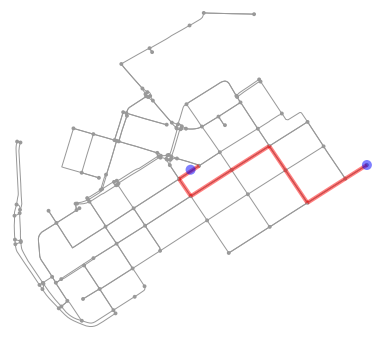

<Figure size 432x288 with 0 Axes>

In [28]:
fig, ax = ox.plot_graph_route(graph_proj, route, origin_point=orig_xy, destination_point=target_xy)

plt.tight_layout()


Awesome! Now we have a the shortest path between our origin and target locations. Being able to analyze shortest paths between locations can be valuable information for many applications. Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

# Helsinki Finland shortest path